# Insurance cross-selling

The goal is to develop a machine learning model that predicts whether customers, who currently have health insurance, might be interested in an insurance policy for their vehicle.

### EDA and preprocessing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

Read and explore dataset

In [6]:
df = pd.read_csv('insurance_cross_sell.csv')
df = df.drop('id', axis=1)

df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [7]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Check missing data

In [9]:
df.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Encoding features

In [11]:
Gender_mapping = {'Female':0, 'Male':1}
df['Gender'] = df['Gender'].map(Gender_mapping)

df['Vehicle_Age'].unique()
Vehicle_Age_mapping = {'< 1 Year':0, '1-2 Year':1, '> 2 Years':2}
df['Vehicle_Age'] = df['Vehicle_Age'].map(Vehicle_Age_mapping)

Vehicle_Damage_mapping = {'No':0, 'Yes':1}
df['Vehicle_Damage'] = df['Vehicle_Damage'].map(Vehicle_Damage_mapping)

Check the processed dataset and its features type

In [13]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0


In [14]:
df.dtypes

Gender                    int64
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age               int64
Vehicle_Damage            int64
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

Select features and target variable

In [16]:
X_clean = df.drop(['Response'], axis=1).values
y_clean = df['Response'].values

Split the dataset in train and test sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=.2, random_state=0)

Features scaling

In [20]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

Defining useful functions for model evaluation

In [33]:
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision_recall=True):
    """
    Plots confusion matrix
    """
    
    cm = confusion_matrix(y_true, y_pred)
    
    df_cm = pd.DataFrame(cm, index = labels, columns = ["Predicted "+labels[0],"Predicted "+labels[1]])
    sns.heatmap(df_cm, annot=True, fmt='g')
    
    if show_precision_recall:
        plt.text(0, -0.1, f"Precision: {(cm[1][1]/(cm[1][1]+cm[0][1])):.3f}")
        plt.text(1, -0.1, f"Recall: {(cm[1][1]/(cm[1][1]+cm[1][0])):.3f}")

In [35]:
def model_evaluation (model, X, y, thresh=0.5):
    """
    Prints complete model evaluation report, with classification report, confusion matrix and ROC curve.
    Also takes custom threshold as argument.
    """
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)
    y_pred = np.where(y_prob[:,1]>thresh,1,0)
    
    
    print('Report')
    print(classification_report(y, y_pred))
    
    plot_confusion_matrix(y, y_pred,labels=['No buy', 'Buy'])
    
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
    display.plot()
    plt.show()
    

### Model development

#### Simple Logistic Regression

At first a simple Logistic Regression with no specific hyperparameters is tried.

In [40]:
lr_1 = LogisticRegression()
lr_1.fit(X_train, y_train)

LogisticRegression()

Report
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    267553
           1       0.35      0.00      0.00     37334

    accuracy                           0.88    304887
   macro avg       0.61      0.50      0.47    304887
weighted avg       0.81      0.88      0.82    304887



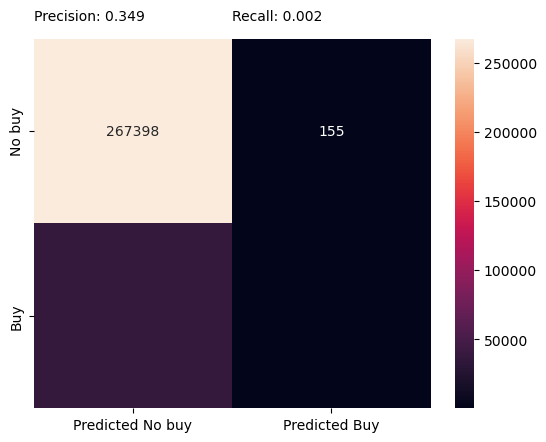

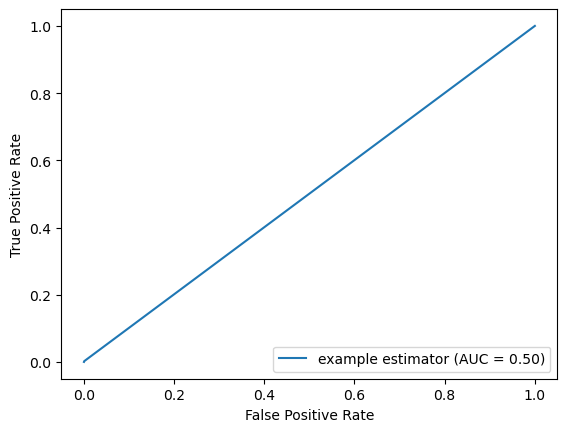

In [41]:
model_evaluation(lr_1, X_train, y_train)

Report
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66846
           1       0.43      0.00      0.00      9376

    accuracy                           0.88     76222
   macro avg       0.65      0.50      0.47     76222
weighted avg       0.82      0.88      0.82     76222



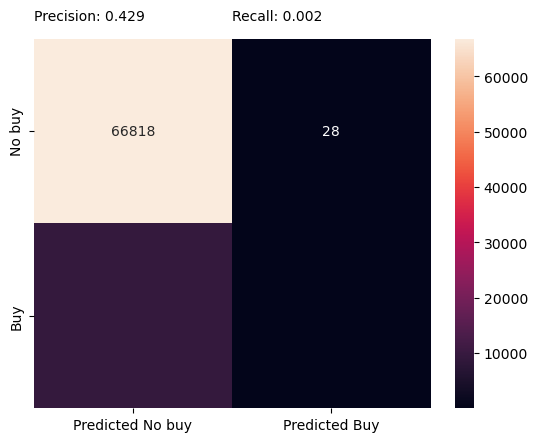

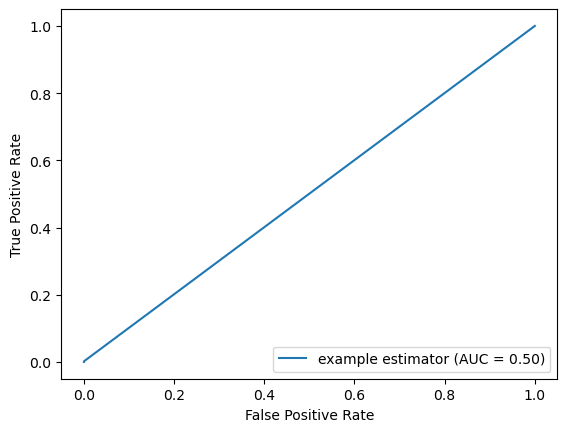

In [44]:
model_evaluation(lr_1, X_test, y_test)

The performance is poor in both train and test set

In [47]:
df['Response'].sum()/df['Response'].shape[0]*100

12.256336113815209

As seen previously, the target variable is quite imbalanced (only 12% of samples has a positive label)

#### Logistic Regression - Balanced

A Logistic Regression with *balanced class weight is trained*. This hyperparameter aims to balance the class weight during the training.

In [52]:
lr_bln = LogisticRegression(class_weight="balanced")
lr_bln.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

Report
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    267553
           1       0.25      0.98      0.40     37334

    accuracy                           0.64    304887
   macro avg       0.62      0.78      0.57    304887
weighted avg       0.90      0.64      0.70    304887



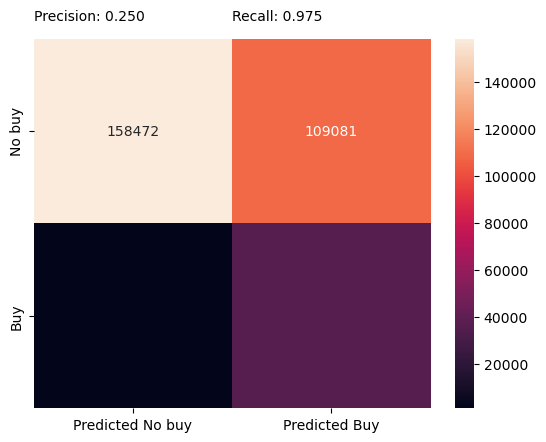

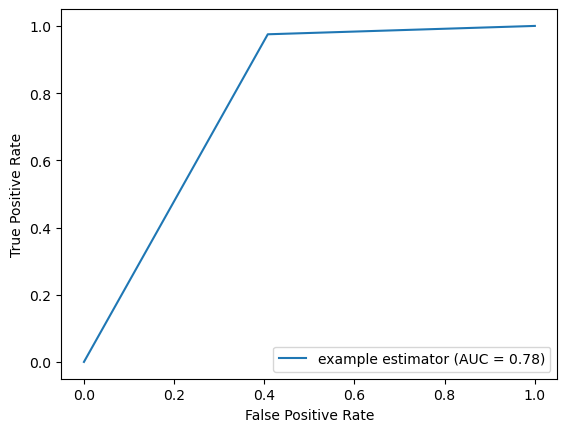

In [54]:
model_evaluation(lr_bln, X_train, y_train)

Report
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66846
           1       0.25      0.98      0.40      9376

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222



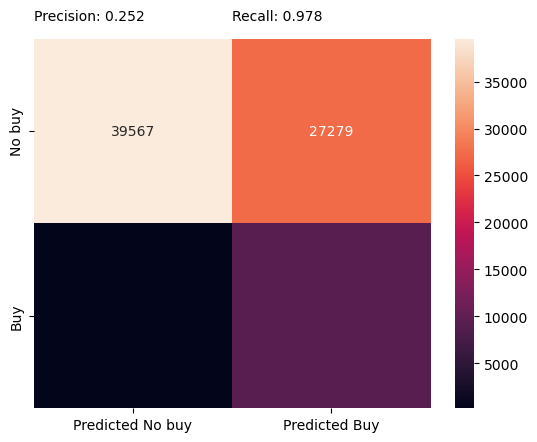

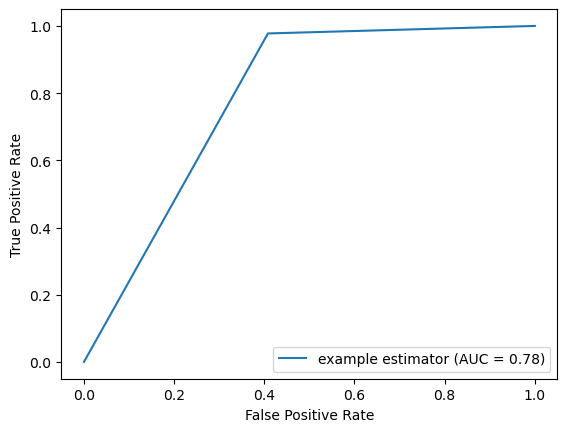

In [55]:
model_evaluation(lr_bln, X_test, y_test)

The model performs better, but still has critical issues. The class weights now appear more balanced and the recall value is very high (0.98), but the precision value is still very small (0.25). In other words, the model classifies a very high portion of false positives, therefore it classifies many customers who did not purchase the auto policy as customers who did. In contrast, the portion of false negatives is very small. The model now “works well” on the negative class. Compared with the initial model, the value of the area under the ROC curve has also improved, rising to 0.78

#### Undersampled model

Given the persistent issues and the wide availability of data (dataset with more than 380.000 samples), I try to use the undersampling technique, using the Imbalanced Learning library.
With this technique the dataset is “shrunk down,” keeping all the observations of the least present class (in this case the positive one) and selecting a random sample of equal number (or custom) of observations of the most present class (in this case the negative one), so that the model can work on a balanced dataset.

In [61]:
print(df['Response'].value_counts())

0    334399
1     46710
Name: Response, dtype: int64


In [63]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_clean, y_clean)
np.unique(y_under, return_counts=True)

(array([0, 1], dtype=int64), array([46710, 46710], dtype=int64))

After applying the *UnderSampler*, the dataset has been reduced and has now a perfectly balanced target.

The balanced dataset is split and scaled, and the model trained

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, random_state=0)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)


lr_under = LogisticRegression()
lr_under.fit(X_train, y_train)

LogisticRegression()

Report
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     35096
           1       0.70      0.98      0.82     34969

    accuracy                           0.78     70065
   macro avg       0.83      0.78      0.78     70065
weighted avg       0.83      0.78      0.78     70065



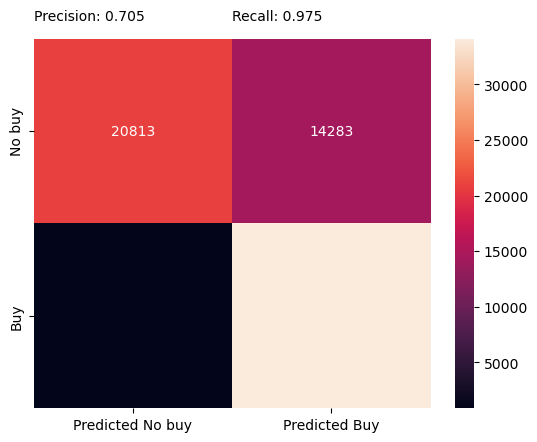

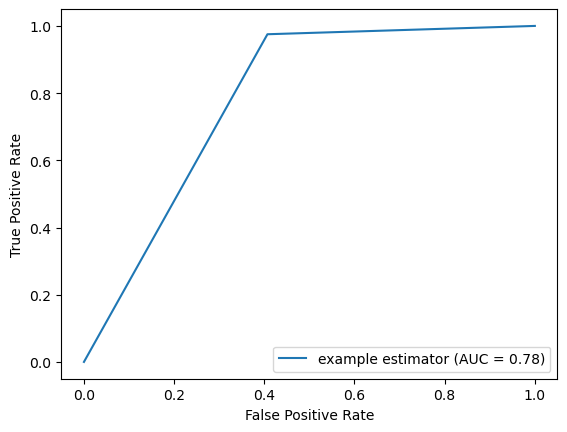

In [69]:
model_evaluation(lr_under, X_train, y_train)

Report
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     11614
           1       0.71      0.98      0.82     11741

    accuracy                           0.79     23355
   macro avg       0.84      0.79      0.78     23355
weighted avg       0.83      0.79      0.78     23355



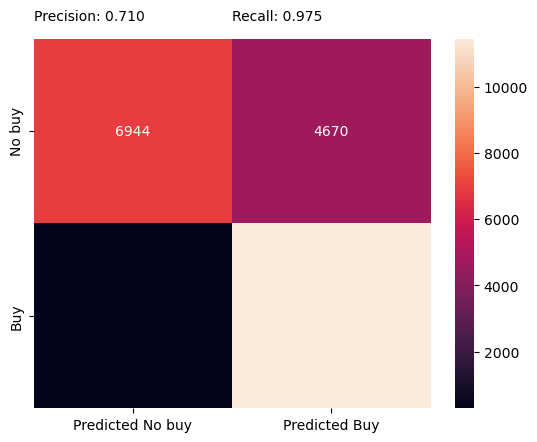

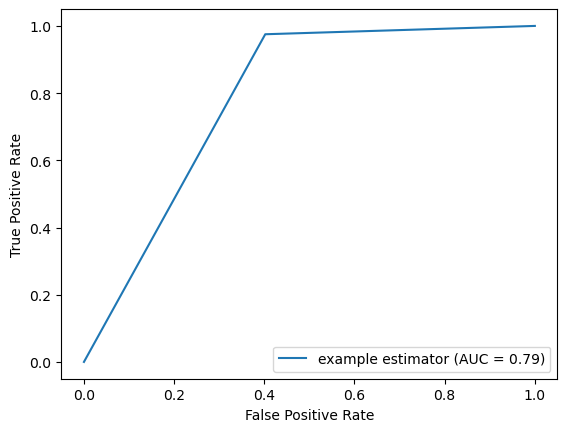

In [70]:
model_evaluation(lr_under, X_test, y_test)

After resizing and rebalancing the dataset, with a 1:1 proportion between classes, I notice a significant improvement: with a substantially unchanged recall (0.98), the model now has a precision value of 0.71. This means that the number of false positives has decreased significantly and that more than 70% of the customers the model classified as “buy” actually bought the policy, and that 98% of the customers who bought the policy were correctly classified by the model. The area under the ROC curve also increased slightly (0.79) and the accuracy value is 0.79.

The model now performs sufficiently well for the prediction of the Response variable.

#### Adjusting the threshold

Although the amount of false positives has been greatly reduced with the *lr_under* model, I try to think about the significance of the classification, in economic terms, for the insurance company. I imagine that the prediction model can be used to figure out which customers to allocate resources to, such as budgets for advertising campaigns or investments on promotional activities. In particular, where these activities have particularly high costs, targeting a significant number of false positives could result in an unprofitable investment.

I therefore try to penalize false positives by increasing the value of the decision threshold, so far equal to the default value 0.5. Analyzing the probability distribution that the model assigns to each observation, I notice that the median is 0.66 and I therefore guess that there are many observations around this probability value. I then try to re-estimate the model with thresholds close to this value, observing the variation in the metrics.

In [76]:
df_proba = pd.DataFrame()
y_proba = lr_under.predict_proba(X_train)
df_proba['prob'] = y_proba[:,1].round(2)
df_proba['prob'].describe()

count    70065.000000
mean         0.498642
std          0.318845
min          0.000000
25%          0.030000
50%          0.660000
75%          0.740000
max          0.920000
Name: prob, dtype: float64

Evaluate the model with a 0.65 threshold

Report
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     35096
           1       0.76      0.77      0.76     34969

    accuracy                           0.76     70065
   macro avg       0.76      0.76      0.76     70065
weighted avg       0.76      0.76      0.76     70065



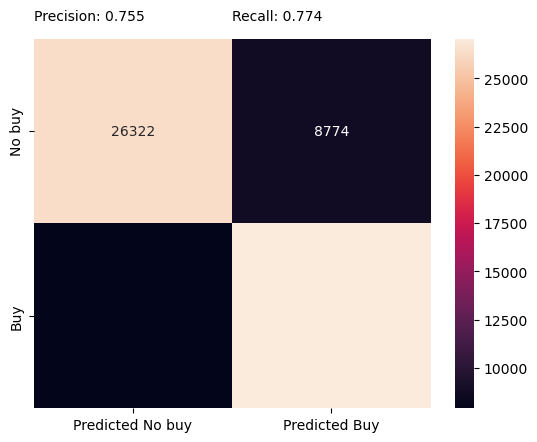

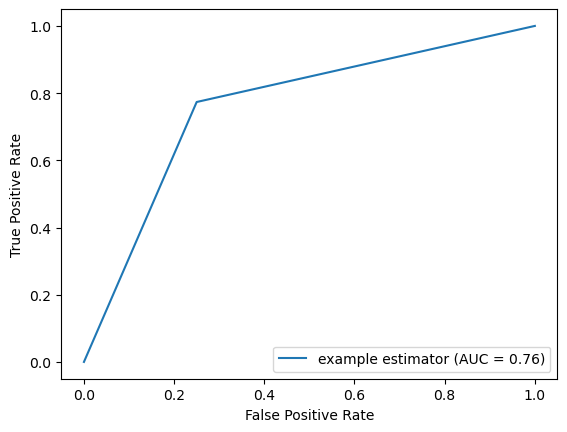

In [79]:
model_evaluation(lr_under, X_train, y_train, thresh=0.65)

Report
              precision    recall  f1-score   support

           0       0.76      0.75      0.76     11614
           1       0.76      0.77      0.76     11741

    accuracy                           0.76     23355
   macro avg       0.76      0.76      0.76     23355
weighted avg       0.76      0.76      0.76     23355



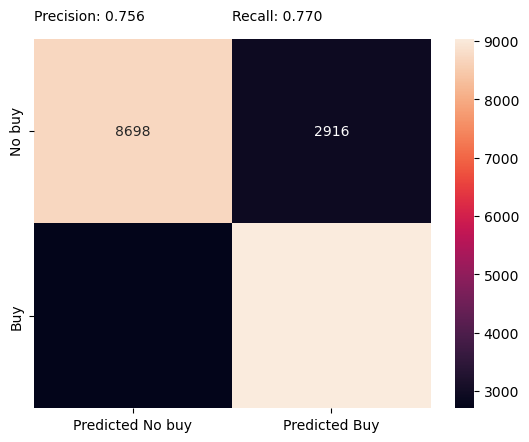

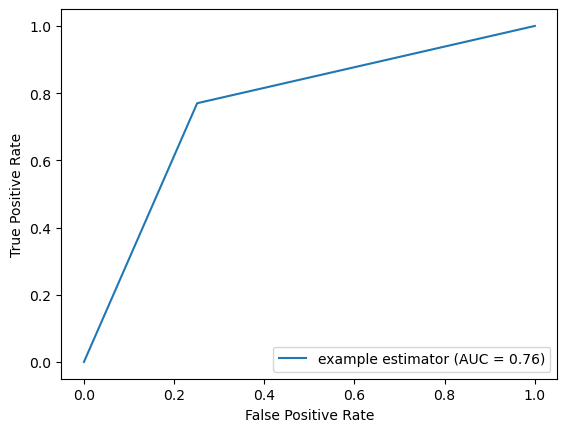

In [80]:
model_evaluation(lr_under, X_test, y_test, thresh=0.65)

I can see improvements with a threshold of 0.65. In this case, the amount of false positives decreased, increasing the precision to 0.75. It should be noted, however, that in absolute terms, the number of true positives also decreased. In addition, the number of false negatives increased, bringing recall to lower levels, at 0.77 and overall accuracy to 0.76. The area under the ROC also decreases.

This model seems to better generalize customer behavior and more correctly estimate the size of potentially affected customers. On the other hand, compared to the model with threshold at 0.5, the increase in precision does not seem so significant compared to the sharp decline in recall and the reduction in other metrics.

I think the decision on which model to use may depend on the cost, in terms of resources, of the company's promotional activities. If these were high, a more cautious attitude and using the higher threshold model might be appropriate. Otherwise, with a more aggressive approach one could use the model with threshold 0.5.